# Import & configure library

In [1]:
import platform
import time
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sklearn


In [2]:
print(f'{platform.python_version()=}')

print(f'{np.__version__=}')
print(f'{pd.__version__=}')
print(f'{matplotlib.__version__=}')
print(f'{sklearn.__version__=}')


platform.python_version()='3.8.3rc1'
np.__version__='1.17.4'
pd.__version__='1.0.3'
matplotlib.__version__='3.2.1'
sklearn.__version__='0.22.2.post1'


In [3]:
SEED = 42
np.random.seed(SEED)

START_TIME = time.time()


In [4]:
## Load preprocessed dataset

In [5]:
dataset = pd.read_pickle('./dataset.pk')


# Bag of Words (BoW) word representation

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=100)
X = vectorizer.fit_transform(dataset['content'])


# K-means++

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=SEED, verbose=1, n_init=10, precompute_distances=True)
y_pred = kmeans.fit_predict(X)


Initialization complete
Iteration  0, inertia 16590122.000
Iteration  1, inertia 14059627.278
Iteration  2, inertia 13840531.544
Iteration  3, inertia 13743967.585
Iteration  4, inertia 13715231.639
Iteration  5, inertia 13694956.587
Iteration  6, inertia 13681392.131
Iteration  7, inertia 13668143.799
Iteration  8, inertia 13634187.992
Iteration  9, inertia 13535565.430
Iteration 10, inertia 13498367.218
Iteration 11, inertia 13485959.096
Iteration 12, inertia 13475569.710
Iteration 13, inertia 13465296.985
Iteration 14, inertia 13458147.462
Iteration 15, inertia 13454197.315
Iteration 16, inertia 13452184.154
Iteration 17, inertia 13451012.355
Iteration 18, inertia 13450252.191
Iteration 19, inertia 13449658.387
Iteration 20, inertia 13449209.492
Iteration 21, inertia 13448733.364
Iteration 22, inertia 13448132.169
Iteration 23, inertia 13447501.940
Iteration 24, inertia 13446854.992
Iteration 25, inertia 13446405.031
Iteration 26, inertia 13446100.706
Iteration 27, inertia 13445915.

# PCA for 3D visualization

In [25]:
from sklearn.decomposition import PCA, TruncatedSVD
pca = [
    PCA(n_components=3, svd_solver='full', random_state=SEED),
    PCA(n_components=3, svd_solver='arpack', random_state=SEED),
    PCA(n_components=3, svd_solver='randomized', random_state=SEED),
    TruncatedSVD(n_components=3, algorithm='arpack', random_state=SEED),
    TruncatedSVD(n_components=3, algorithm='randomized', n_iter=10, random_state=SEED)
]
pca_variance = []

for i in range(len(pca)):
    try:
        pca[i] = pca[i].fit(X)
    except:
        if X.dtype == np.int64:
            pca[i] = pca[i].fit(X.astype(np.float64).toarray())
        else:
            pca[i] = pca[i].fit(X.toarray())

    gc.collect()
    print(f'Variance for pca[{i}] : {pca[i].explained_variance_ratio_.sum()}')
    pca_variance.append(pca[i].explained_variance_ratio_.sum())

# select best PCA
index_best_pca = pca_variance.index(max(pca_variance))
X_reduced = pca[i].transform(X)


Variance for pca[0] : 0.07583636324155489
Variance for pca[1] : 0.0758363632415553
Variance for pca[2] : 0.07583634987659169
Variance for pca[3] : 0.07178428910855322
Variance for pca[4] : 0.07178428798327137


# Cluster 3D visualization

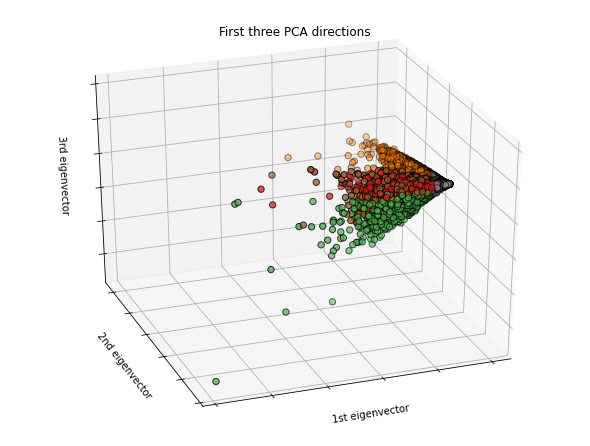

In [26]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_pred,
           cmap='Set1', edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()



# Supervised evaluation

In [28]:
y_true = dataset['topic'].to_list()


In [29]:
from sklearn import metrics
y_true = dataset['topic'].to_list()


In [30]:
print(f'{metrics.adjusted_rand_score(y_true, y_pred)=}')
print(f'{metrics.homogeneity_score(y_true, y_pred)=}')
print(f'{metrics.completeness_score(y_true, y_pred)=}')
print(f'{metrics.v_measure_score(y_true, y_pred)=}')
print(f'{metrics.fowlkes_mallows_score(y_true, y_pred)=}')


metrics.adjusted_rand_score(y_true, y_pred)=0.16832494978963927
metrics.homogeneity_score(y_true, y_pred)=0.3867110347229015
metrics.completeness_score(y_true, y_pred)=0.47799410872503256
metrics.v_measure_score(y_true, y_pred)=0.42753439777044283
metrics.fowlkes_mallows_score(y_true, y_pred)=0.4217245815042002


# Unsupervised evaluation

In [41]:
print(f'{metrics.calinski_harabasz_score(X.toarray(), y_pred)=}')
print(f'{metrics.silhouette_score(X, y_pred, sample_size=X.shape[0] // 5)=}')
print(f'{metrics.davies_bouldin_score(X.toarray(), y_pred)=}')


metrics.calinski_harabasz_score(X.toarray(), y_pred)=676.2524626345348
metrics.silhouette_score(X, y_pred, sample_size=X.shape[0] // 5)=0.04580253760601429
metrics.davies_bouldin_score(X.toarray(), y_pred)=5.378978998734258


In [42]:
END_TIME = time.time()
TOTAL_SECONDS = START_TIME - END_TIME
print(f'{TOTAL_SECONDS=}')


TOTAL_SECONDS=-3030.661610841751
